# 共享单车数据预测——线性回归分析
数据说明： Capital Bikeshare （美国Washington, D.C.的一个共享单车公司）提供的共享单车数据。数据包含每天的日期、天气等信息，需要预测每天的共享单车骑行量。

1、导入必要的工具包

In [1]:
import numpy as np  # 矩阵操作
import pandas as pd # SQL数据处理

from sklearn.metrics import r2_score  #评价回归预测模型的性能

import matplotlib.pyplot as plt   #画图
import seaborn as sns

# 图形出现在Notebook里而不是新窗口
%matplotlib inline

2、数据探索

2.1 读取数据

In [2]:
# path to where the data lies
#dpath = './data/'
data = pd.read_csv("day.csv")

#通过观察前5行，了解数据每列（特征）的概况
data.head()

instant      dteday  season  yr  mnth  holiday  weekday  workingday  \
0        1  2011-01-01       1   0     1        0        6           0   
1        2  2011-01-02       1   0     1        0        0           0   
2        3  2011-01-03       1   0     1        0        1           1   
3        4  2011-01-04       1   0     1        0        2           1   
4        5  2011-01-05       1   0     1        0        3           1   

   weathersit      temp     atemp       hum  windspeed  casual  registered  \
0           2  0.344167  0.363625  0.805833   0.160446     331         654   
1           2  0.363478  0.353739  0.696087   0.248539     131         670   
2           1  0.196364  0.189405  0.437273   0.248309     120        1229   
3           1  0.200000  0.212122  0.590435   0.160296     108        1454   
4           1  0.226957  0.229270  0.436957   0.186900      82        1518   

    cnt  
0   985  
1   801  
2  1349  
3  1562  
4  1600

2.2 数据基本信息
样本数目、特征维数
每个特征的类型、空值样本的数目、数据类型

In [3]:
data.shape

(731, 16)

2.3 数据探索
请见另一个文件：1week_0_Explore.pynb

对数据的探索有助于我们在第三步中根据数据的特点选择合适的模型类型

2.4 数据准备

In [4]:
# 从原始数据中分离输入特征x和输出y
y = data['cnt'].values

#分离一下无用的特征
data_remove = data.drop('instant',axis = 1)
data_remove = data_remove.drop('dteday',axis = 1)
data_remove = data_remove.drop('season',axis = 1)
data_remove = data_remove.drop('yr',axis = 1)
data_remove = data_remove.drop('mnth',axis = 1)
data_remove = data_remove.drop('casual',axis = 1)
data_remove = data_remove.drop('registered',axis = 1)
X = data_remove.drop('cnt',axis = 1)

#用于后续显示权重系数对应的特征
columns = X.columns
print(columns)

Index(['holiday', 'weekday', 'workingday', 'weathersit', 'temp', 'atemp',
       'hum', 'windspeed'],
      dtype='object')


In [5]:
#将数据分割训练数据与测试数据
from sklearn.model_selection import train_test_split

# 随机采样20%的数据构建测试样本，其余作为训练样本
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=None, test_size=0.2)
X_train.shape

(584, 8)

2.5 数据预处理／特征工程
特征工程是实际任务中特别重要的环节。

In [6]:
# 数据标准化
from sklearn.preprocessing import StandardScaler

# 分别初始化对特征和目标值的标准化器
ss_X = StandardScaler()
ss_y = StandardScaler()

# 分别对训练和测试数据的特征以及目标值进行标准化处理
X_train = ss_X.fit_transform(X_train)
X_test = ss_X.transform(X_test)

#对y做标准化不是必须
#对y标准化的好处是不同问题的w差异不太大，同时正则参数的范围也有限
y_train = ss_y.fit_transform(y_train.reshape(-1, 1))
y_test = ss_y.transform(y_test.reshape(-1, 1))

C:\Users\YuGo\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\YuGo\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\YuGo\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


3、确定模型类型

3.1 尝试缺省参数的线性回归

In [7]:
# 线性回归
#class sklearn.linear_model.LinearRegression(fit_intercept=True, normalize=False, copy_X=True, n_jobs=1)
from sklearn.linear_model import LinearRegression

# 使用默认配置初始化
lr = LinearRegression()

# 训练模型参数
lr.fit(X_train, y_train)

# 预测
y_test_pred_lr = lr.predict(X_test)
y_train_pred_lr = lr.predict(X_train)


# 看看各特征的权重系数，系数的绝对值大小可视为该特征的重要性
fs = pd.DataFrame({"columns":list(columns), "coef":list((lr.coef_.T))})
fs.sort_values(by=['coef'],ascending=False)

columns                     coef
5       atemp     [0.3414704504662848]
4        temp    [0.25995770984583483]
1     weekday    [0.05959606113987586]
2  workingday    [0.03703338474130662]
0     holiday  [-0.027165022849018075]
3  weathersit    [-0.1224343063929487]
7   windspeed   [-0.14798511879908544]
6         hum   [-0.16007614239866622]

3.1.1 模型评价

In [8]:
# 使用r2_score评价模型在测试集和训练集上的性能，并输出评估结果
#测试集
print ('The r2 score of LinearRegression on test is', r2_score(y_test, y_test_pred_lr))
#训练集
print ('The r2 score of LinearRegression on train is', r2_score(y_train, y_train_pred_lr))

The r2 score of LinearRegression on test is 0.49831584608815194
The r2 score of LinearRegression on train is 0.4757195027526391


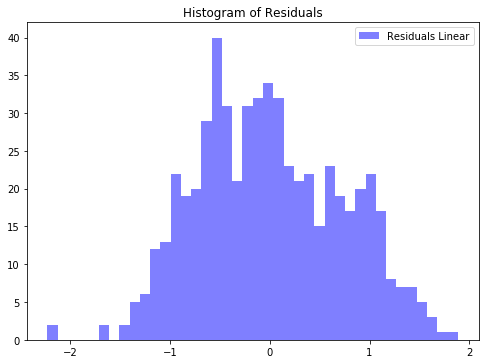

In [9]:
#在训练集上观察预测残差的分布，看是否符合模型假设：噪声为0均值的高斯噪声
f, ax = plt.subplots(figsize=(7, 5)) 
f.tight_layout() 
ax.hist(y_train - y_train_pred_lr,bins=40, label='Residuals Linear', color='b', alpha=.5); 
ax.set_title("Histogram of Residuals") 
ax.legend(loc='best');

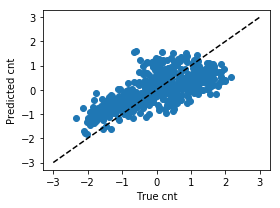

In [10]:
#还可以观察预测值与真值的散点图
plt.figure(figsize=(4, 3))
plt.scatter(y_train, y_train_pred_lr)
plt.plot([-3, 3], [-3, 3], '--k')   #数据已经标准化，3倍标准差即可
plt.axis('tight')
plt.xlabel('True cnt')
plt.ylabel('Predicted cnt')
plt.tight_layout()

In [11]:
#岭回归／L2正则
#class sklearn.linear_model.RidgeCV(alphas=(0.1, 1.0, 10.0), fit_intercept=True, 
#                                  normalize=False, scoring=None, cv=None, gcv_mode=None, 
#                                  store_cv_values=False)
from sklearn.linear_model import  RidgeCV

#设置超参数（正则参数）范围
alphas = [ 0.01, 0.1, 1, 10,100]
#n_alphas = 20
#alphas = np.logspace(-5,2,n_alphas)

#生成一个RidgeCV实例
ridge = RidgeCV(alphas=alphas, store_cv_values=True)  

#模型训练
ridge.fit(X_train, y_train)    

#预测
y_test_pred_ridge = ridge.predict(X_test)
y_train_pred_ridge = ridge.predict(X_train)


# 评估，使用r2_score评价模型在测试集和训练集上的性能
print ('The r2 score of RidgeCV on test is', r2_score(y_test, y_test_pred_ridge))
print ('The r2 score of RidgeCV on train is', r2_score(y_train, y_train_pred_ridge))

The r2 score of RidgeCV on test is 0.4939879025732826
The r2 score of RidgeCV on train is 0.47227937418192034


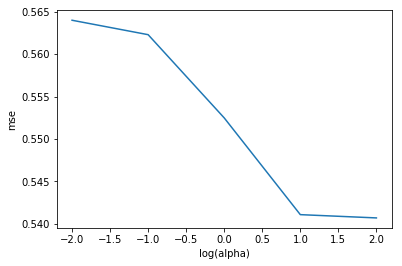

alpha is: 100.0


columns                  coef_lr              coef_ridge
5       atemp     [0.3414704504662848]   [0.27902244130325116]
4        temp    [0.25995770984583483]   [0.27453834808757577]
1     weekday    [0.05959606113987586]  [0.052878680766823116]
2  workingday    [0.03703338474130662]  [0.032779751173616464]
0     holiday  [-0.027165022849018075]  [-0.02439314298027631]
3  weathersit    [-0.1224343063929487]  [-0.12784764573223628]
7   windspeed   [-0.14798511879908544]  [-0.12773419510294065]
6         hum   [-0.16007614239866622]  [-0.12687929764710046]

In [12]:
mse_mean = np.mean(ridge.cv_values_, axis = 0)
plt.plot(np.log10(alphas), mse_mean.reshape(len(alphas),1)) 

#这是为了标出最佳参数的位置，不是必须
#plt.plot(np.log10(ridge.alpha_)*np.ones(3), [0.28, 0.29, 0.30])

plt.xlabel('log(alpha)')
plt.ylabel('mse')
plt.show()

print ('alpha is:', ridge.alpha_)

# 看看各特征的权重系数，系数的绝对值大小可视为该特征的重要性
fs = pd.DataFrame({"columns":list(columns), "coef_lr":list((lr.coef_.T)), "coef_ridge":list((ridge.coef_.T))})
fs.sort_values(by=['coef_lr'],ascending=False)

In [13]:
#### Lasso／L1正则
# class sklearn.linear_model.LassoCV(eps=0.001, n_alphas=100, alphas=None, fit_intercept=True, 
#                                    normalize=False, precompute=’auto’, max_iter=1000, 
#                                    tol=0.0001, copy_X=True, cv=None, verbose=False, n_jobs=1,
#                                    positive=False, random_state=None, selection=’cyclic’)
from sklearn.linear_model import LassoCV

#设置超参数搜索范围
#alphas = [ 0.01, 0.1, 1, 10,100]

#生成一个LassoCV实例
#lasso = LassoCV(alphas=alphas)  
lasso = LassoCV()  

#训练（内含CV）
lasso.fit(X_train, y_train)  

#测试
y_test_pred_lasso = lasso.predict(X_test)
y_train_pred_lasso = lasso.predict(X_train)


# 评估，使用r2_score评价模型在测试集和训练集上的性能
print ('The r2 score of LassoCV on test is', r2_score(y_test, y_test_pred_lasso))
print ('The r2 score of LassoCV on train is', r2_score(y_train, y_train_pred_lasso))

The r2 score of LassoCV on test is 0.4976622423904308
The r2 score of LassoCV on train is 0.47559379515164024


C:\Users\YuGo\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:1094: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


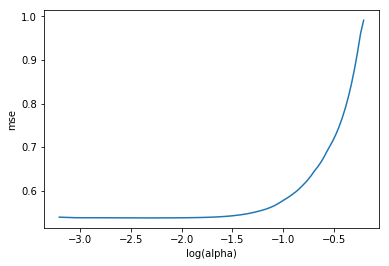

alpha is: 0.004716313265995606


columns                  coef_lr              coef_ridge  coef_lasso
5       atemp     [0.3414704504662848]   [0.27902244130325116]    0.338881
4        temp    [0.25995770984583483]   [0.27453834808757577]    0.258295
1     weekday    [0.05959606113987586]  [0.052878680766823116]    0.055673
2  workingday    [0.03703338474130662]  [0.032779751173616464]    0.033285
0     holiday  [-0.027165022849018075]  [-0.02439314298027631]   -0.023631
3  weathersit    [-0.1224343063929487]  [-0.12784764573223628]   -0.121343
7   windspeed   [-0.14798511879908544]  [-0.12773419510294065]   -0.143046
6         hum   [-0.16007614239866622]  [-0.12687929764710046]   -0.154900

In [14]:
mses = np.mean(lasso.mse_path_, axis = 1)
plt.plot(np.log10(lasso.alphas_), mses) 
#plt.plot(np.log10(lasso.alphas_)*np.ones(3), [0.3, 0.4, 1.0])
plt.xlabel('log(alpha)')
plt.ylabel('mse')
plt.show()    
            
print ('alpha is:', lasso.alpha_)

# 看看各特征的权重系数，系数的绝对值大小可视为该特征的重要性
fs = pd.DataFrame({"columns":list(columns), "coef_lr":list((lr.coef_.T)), "coef_ridge":list((ridge.coef_.T)), "coef_lasso":list((lasso.coef_.T))})
fs.sort_values(by=['coef_lr'],ascending=False)

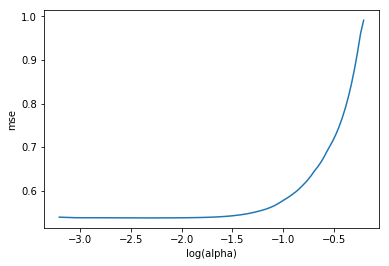

alpha is: 0.004716313265995606


In [15]:
mses = np.mean(lasso.mse_path_, axis = 1)
plt.plot(np.log10(lasso.alphas_), mses) 
#plt.plot(np.log10(lasso.alphas_)*np.ones(3), [0.3, 0.4, 1.0])
plt.xlabel('log(alpha)')
plt.ylabel('mse')
plt.show()    
            
print ('alpha is:', lasso.alpha_)